In [28]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import zipfile

In [29]:
# Download file zip berisikan gambar
!wget --no-check-certificate \
  https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip?raw=true \
  -O /tmp/trashnet.zip

--2020-06-19 08:02:02--  https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip [following]
--2020-06-19 08:02:02--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2020-06-19 08:02:02--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... con

In [30]:
# Ekstrak file Zip
local_zip = '/tmp/trashnet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [31]:
def image_plot(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs[:5]]
    
    plt.figure(figsize=(12,14))
    
    for idx, img_path in enumerate(item_files):
        plt.subplot(5,5,idx+1)
        
        img=plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')

In [32]:
print(os.listdir('/tmp/dataset-resized'))

['metal', 'glass', '.DS_Store', 'paper', 'trash', 'plastic', 'cardboard']


In [33]:
data_path = '/tmp/dataset-resized'

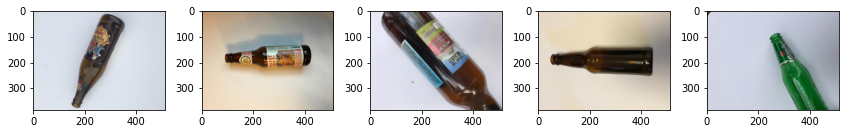

In [34]:
image_plot(data_path+'/glass')

In [35]:
train = ImageDataGenerator(rotation_range = 90,horizontal_flip=True, vertical_flip=True, validation_split=0.2, rescale=1./255,
                           shear_range=0.2,zoom_range=0.4, width_shift_range=0.2,height_shift_range=0.2,fill_mode='nearest')

test = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [36]:
train_generator = train.flow_from_directory(data_path,target_size=(224,224),batch_size=11, class_mode='categorical',
                                            subset='training', shuffle=True)

test_generator = test.flow_from_directory(data_path,target_size=(224,224),batch_size=11, class_mode='categorical',
                                            subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [37]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [38]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                              include_top=False, 
                                              weights='imagenet')

In [39]:
base_model.trainable = False

In [40]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(6, activation='softmax')
])

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 2,626,854
Trainable params: 368,870
Non-trainable params: 2,257,984
_________________________________________________________________


In [43]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [44]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=test_generator, 
                    validation_steps=len(test_generator))

Epoch 1/10
184/184 [==============================] - 38s 208ms/step - loss: 1.0721 - accuracy: 0.6136 - val_loss: 0.9534 - val_accuracy: 0.6342
Epoch 2/10
184/184 [==============================] - 37s 201ms/step - loss: 0.7658 - accuracy: 0.7243 - val_loss: 0.7591 - val_accuracy: 0.7038
Epoch 3/10
184/184 [==============================] - 35s 191ms/step - loss: 0.6994 - accuracy: 0.7540 - val_loss: 0.8361 - val_accuracy: 0.6938
Epoch 4/10
184/184 [==============================] - 35s 188ms/step - loss: 0.6174 - accuracy: 0.7846 - val_loss: 0.8204 - val_accuracy: 0.7097
Epoch 5/10
184/184 [==============================] - 34s 187ms/step - loss: 0.5610 - accuracy: 0.7969 - val_loss: 0.7812 - val_accuracy: 0.7495
Epoch 6/10
184/184 [==============================] - 35s 189ms/step - loss: 0.5683 - accuracy: 0.7826 - val_loss: 0.8033 - val_accuracy: 0.7217
Epoch 7/10
184/184 [==============================] - 35s 190ms/step - loss: 0.5275 - accuracy: 0.8014 - val_loss: 0.8619 - val_ac

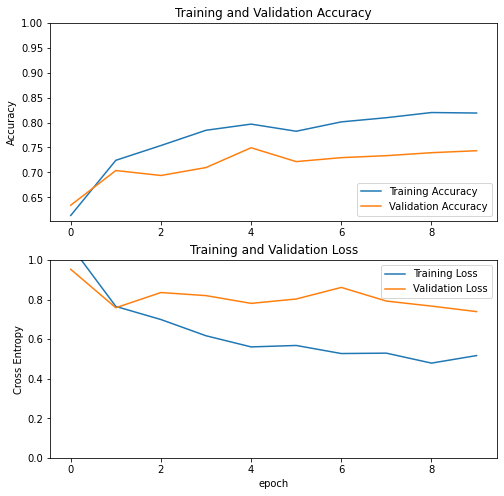

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
base_model.trainable = True

In [47]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 110

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [48]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 2,626,854
Trainable params: 2,112,038
Non-trainable params: 514,816
_________________________________________________________________


In [50]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 49


In [51]:
model_path='new_transfer_learning'
checkpoint1 = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

In [52]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=20, 
                         validation_data=test_generator, 
                         validation_steps=len(test_generator),
                         verbose = 1,
                         callbacks=callbacks_list)

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.9260 - accuracy: 0.6700
Epoch 00001: val_accuracy improved from -inf to 0.73559, saving model to new_transfer_learning
INFO:tensorflow:Assets written to: new_transfer_learning/assets


INFO:tensorflow:Assets written to: new_transfer_learning/assets


184/184 [==============================] - 66s 359ms/step - loss: 0.9260 - accuracy: 0.6700 - val_loss: 0.7839 - val_accuracy: 0.7356
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.7233
Epoch 00002: val_accuracy improved from 0.73559 to 0.74155, saving model to new_transfer_learning
INFO:tensorflow:Assets written to: new_transfer_learning/assets


INFO:tensorflow:Assets written to: new_transfer_learning/assets


184/184 [==============================] - 68s 371ms/step - loss: 0.7433 - accuracy: 0.7233 - val_loss: 0.7764 - val_accuracy: 0.7416
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.7446
Epoch 00003: val_accuracy improved from 0.74155 to 0.74354, saving model to new_transfer_learning
INFO:tensorflow:Assets written to: new_transfer_learning/assets


INFO:tensorflow:Assets written to: new_transfer_learning/assets


184/184 [==============================] - 68s 372ms/step - loss: 0.7097 - accuracy: 0.7446 - val_loss: 0.7694 - val_accuracy: 0.7435
Epoch 4/20
184/184 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.7619
Epoch 00004: val_accuracy did not improve from 0.74354
184/184 [==============================] - 37s 199ms/step - loss: 0.6752 - accuracy: 0.7619 - val_loss: 0.7482 - val_accuracy: 0.7316
Epoch 5/20
184/184 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.7698
Epoch 00005: val_accuracy did not improve from 0.74354
184/184 [==============================] - 36s 197ms/step - loss: 0.6170 - accuracy: 0.7698 - val_loss: 0.7317 - val_accuracy: 0.7416
Epoch 6/20
184/184 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.7762
Epoch 00006: val_accuracy improved from 0.74354 to 0.76541, saving model to new_transfer_learning
INFO:tensorflow:Assets written to: new_transfer_learning/assets


INFO:tensorflow:Assets written to: new_transfer_learning/assets


184/184 [==============================] - 66s 360ms/step - loss: 0.5964 - accuracy: 0.7762 - val_loss: 0.7205 - val_accuracy: 0.7654
Epoch 7/20
184/184 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.7856
Epoch 00007: val_accuracy did not improve from 0.76541
184/184 [==============================] - 37s 200ms/step - loss: 0.5874 - accuracy: 0.7856 - val_loss: 0.7269 - val_accuracy: 0.7555
Epoch 8/20
184/184 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.8197
Epoch 00008: val_accuracy did not improve from 0.76541
184/184 [==============================] - 37s 200ms/step - loss: 0.5164 - accuracy: 0.8197 - val_loss: 0.7336 - val_accuracy: 0.7555
Epoch 9/20
184/184 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.8132
Epoch 00009: val_accuracy did not improve from 0.76541
184/184 [==============================] - 38s 206ms/step - loss: 0.5353 - accuracy: 0.8132 - val_loss: 0.7378 - val_accuracy: 0.7654
Epoch 10/20

INFO:tensorflow:Assets written to: new_transfer_learning/assets


184/184 [==============================] - 65s 355ms/step - loss: 0.5661 - accuracy: 0.8009 - val_loss: 0.7232 - val_accuracy: 0.7853
Epoch 11/20
184/184 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.8216
Epoch 00011: val_accuracy did not improve from 0.78529
184/184 [==============================] - 37s 201ms/step - loss: 0.4854 - accuracy: 0.8216 - val_loss: 0.7390 - val_accuracy: 0.7853
Epoch 12/20
184/184 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.8172
Epoch 00012: val_accuracy did not improve from 0.78529
184/184 [==============================] - 39s 210ms/step - loss: 0.5227 - accuracy: 0.8172 - val_loss: 0.7162 - val_accuracy: 0.7813
Epoch 13/20
184/184 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.8414
Epoch 00013: val_accuracy did not improve from 0.78529
184/184 [==============================] - 39s 210ms/step - loss: 0.4833 - accuracy: 0.8414 - val_loss: 0.7168 - val_accuracy: 0.7773
Epoch 14

INFO:tensorflow:Assets written to: new_transfer_learning/assets


184/184 [==============================] - 68s 368ms/step - loss: 0.4363 - accuracy: 0.8375 - val_loss: 0.6970 - val_accuracy: 0.7952
Epoch 20/20
184/184 [==============================] - ETA: 0s - loss: 0.4243 - accuracy: 0.8424
Epoch 00020: val_accuracy improved from 0.79523 to 0.79722, saving model to new_transfer_learning
INFO:tensorflow:Assets written to: new_transfer_learning/assets


INFO:tensorflow:Assets written to: new_transfer_learning/assets


184/184 [==============================] - 67s 364ms/step - loss: 0.4243 - accuracy: 0.8424 - val_loss: 0.6983 - val_accuracy: 0.7972


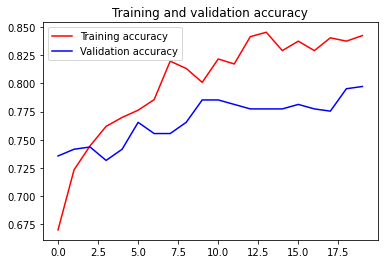

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [54]:
saved_model_dir = 'new_transfer_learning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('newmodel.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: new_transfer_learning/assets


INFO:tensorflow:Assets written to: new_transfer_learning/assets
